In [1]:
import os
HOME = os.getcwd()
print(HOME)

/Users/eric/Desktop/2-Career/Projects/ObjectDetectionLL


### Convert videos into images

**NOTE:** Now, let's convert videos into images. By default, the code below saves every `10th` frame from each video. You can change this by manipulating the value of the `FRAME_STRIDE` parameter.

In [2]:
VIDEO_DIR_PATH = f"{HOME}/videos"
IMAGE_DIR_PATH = f"{HOME}/images"
FRAME_STRIDE = 10

In [3]:
import supervision as sv
from tqdm.notebook import tqdm

video_paths = sv.list_files_with_extensions(
    directory=VIDEO_DIR_PATH,
    extensions=["mov", "mp4"])

TEST_VIDEO_PATHS, TRAIN_VIDEO_PATHS = video_paths[:2], video_paths[2:]

for video_path in tqdm(TRAIN_VIDEO_PATHS):
    video_name = video_path.stem
    image_name_pattern = video_name + "-{:05d}.png"
    with sv.ImageSink(target_dir_path=IMAGE_DIR_PATH, image_name_pattern=image_name_pattern) as sink:
        for image in sv.get_video_frames_generator(source_path=str(video_path), stride=FRAME_STRIDE):
            sink.save_image(image=image)

  0%|          | 0/415 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Display image sample

**NOTE:** Before we start building a model with autodistill, let's make sure we have everything we need.

In [4]:
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 864


In [5]:
IMAGE_DIR_PATH = f"{HOME}/images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

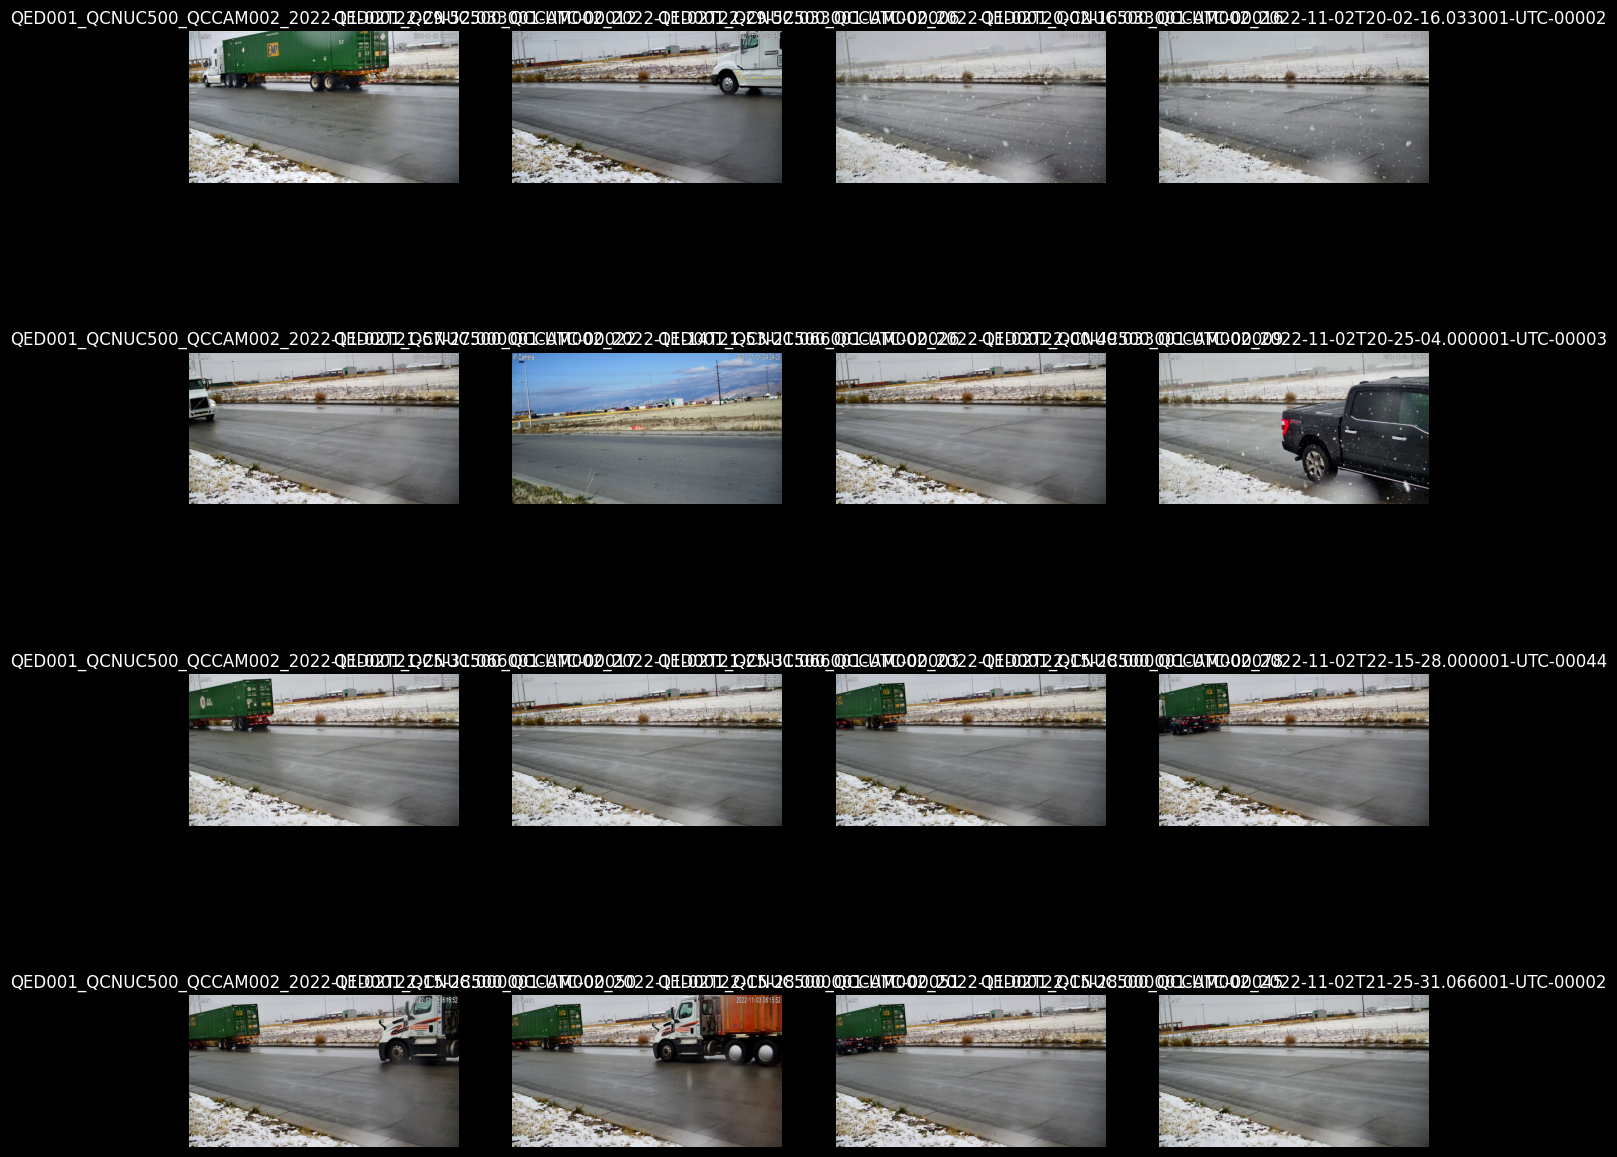

In [6]:
import cv2
import supervision as sv

titles = [image_path.stem for image_path in image_paths[:SAMPLE_SIZE]]
images = [cv2.imread(str(image_path)) for image_path in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

## 🏷️ Autolabel dataset

### Define ontology

**Ontology** - an Ontology defines how your Base Model is prompted, what your Dataset will describe, and what your Target Model will predict. A simple Ontology is the CaptionOntology which prompts a Base Model with text captions and maps them to class names. Other Ontologies may, for instance, use a CLIP vector or example images instead of a text caption.

In [9]:
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "car": "car",
    "truck": "truck",
    "license plate": "license plate"
})

### Initiate base model and autolabel

**Base Model** - A Base Model is a large foundation model that knows a lot about a lot. Base models are often multimodal and can perform many tasks. They're large, slow, and expensive. Examples of Base Models are GroundedSAM and GPT-4's multimodal variant. We use a Base Model (along with unlabeled input data and an Ontology) to create a Dataset.

In [10]:
DATASET_DIR_PATH = f"{HOME}/dataset_mps"

**NOTE:** Base Models are slow... Make yourself a coffee, autolabeing may take a while. ☕

In [11]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".png",
    output_folder=DATASET_DIR_PATH)

MPS Available: True
MPS Available: True
trying to load grounding dino directly


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)


final text_encoder_type: bert-base-uncased


Labeling /Users/eric/Desktop/2-Career/Projects/ObjectDetectionLL/images/QED001_QCNUC500_QCCAM002_2022-11-02T22-29-52.033001-UTC-00012.png:   0%|          | 0/490 [00:00<?, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
Labeling /Users/eric/Desktop/2-Career/Projects/ObjectDetectionLL/images/QED001_QCNUC500_QCCAM002_2022-11-02T22-29-52.033001-UTC-00037.png: 100%|██████████| 490/490 [1:56:54<00:00, 14.32s/it]  


Labeled dataset created - ready for distillation.


### Display dataset sample

**Dataset** - a Dataset is a set of auto-labeled data that can be used to train a Target Model. It is the output generated by a Base Model.

In [12]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [13]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

392

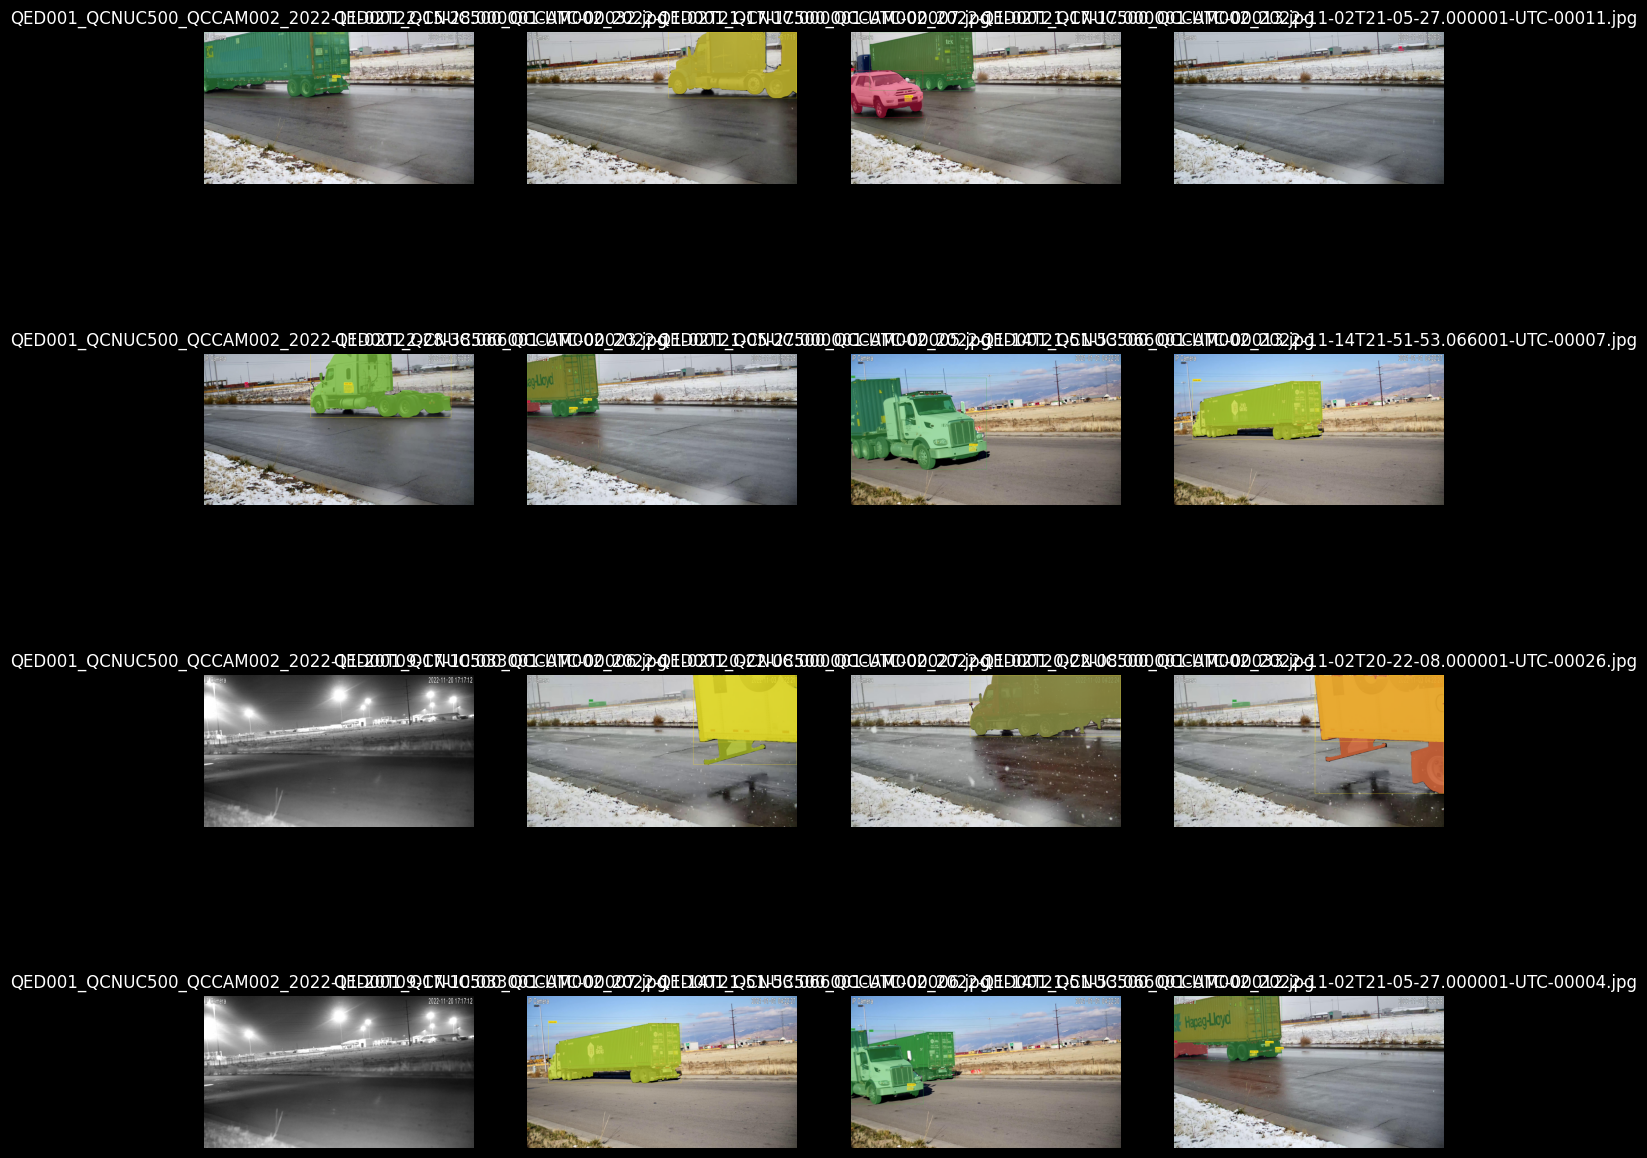

In [14]:
import supervision as sv

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

## 🔥 Train target model - YOLOv8

**Target Model** - a Target Model is a supervised model that consumes a Dataset and outputs a distilled model that is ready for deployment. Target Models are usually small, fast, and fine-tuned to perform a specific task very well (but they don't generalize well beyond the information described in their Dataset). Examples of Target Models are YOLOv8 and DETR.

In [15]:
%cd {HOME}

from autodistill_yolov8 import YOLOv8

target_model = YOLOv8("yolov8n.pt")
target_model.train(DATA_YAML_PATH, epochs=50)

WARNING ⚠️ Ultralytics settings reset to defaults. This is normal and may be due to a recent ultralytics package update, but may have overwritten previous settings. 
View and update settings with 'yolo settings' or at '/Users/eric/Library/Application Support/Ultralytics/settings.yaml'


/Users/eric/Desktop/2-Career/Projects/ObjectDetectionLL


100%|██████████| 6.23M/6.23M [00:00<00:00, 11.5MB/s]
New https://pypi.org/project/ultralytics/8.0.205 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.1.0 CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/eric/Desktop/2-Career/Projects/ObjectDetectionLL/dataset/data.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, vi

In [ ]:
# ########## Should try this with MPS:
# from ultralytics import YOLO

# target_model = YOLO("yolov8n.pt")
# target_model.train(data=DATA_YAML_PATH, epochs=50, device='mps')

In [16]:
!ls {HOME}/runs/detect/train/

F1_curve.png           labels_correlogram.jpg val_batch0_pred.jpg
PR_curve.png           results.csv            val_batch1_labels.jpg
P_curve.png            results.png            val_batch1_pred.jpg
R_curve.png            train_batch0.jpg       val_batch2_labels.jpg
args.yaml              train_batch1.jpg       val_batch2_pred.jpg
confusion_matrix.png   train_batch2.jpg       weights
labels.jpg             val_batch0_labels.jpg


## ⚖️ Evaluate target model

**NOTE:** As with the regular YOLOv8 training, we can now take a look at artifacts stored in `runs` directory.

/Users/eric/Desktop/2-Career/Projects/ObjectDetectionLL


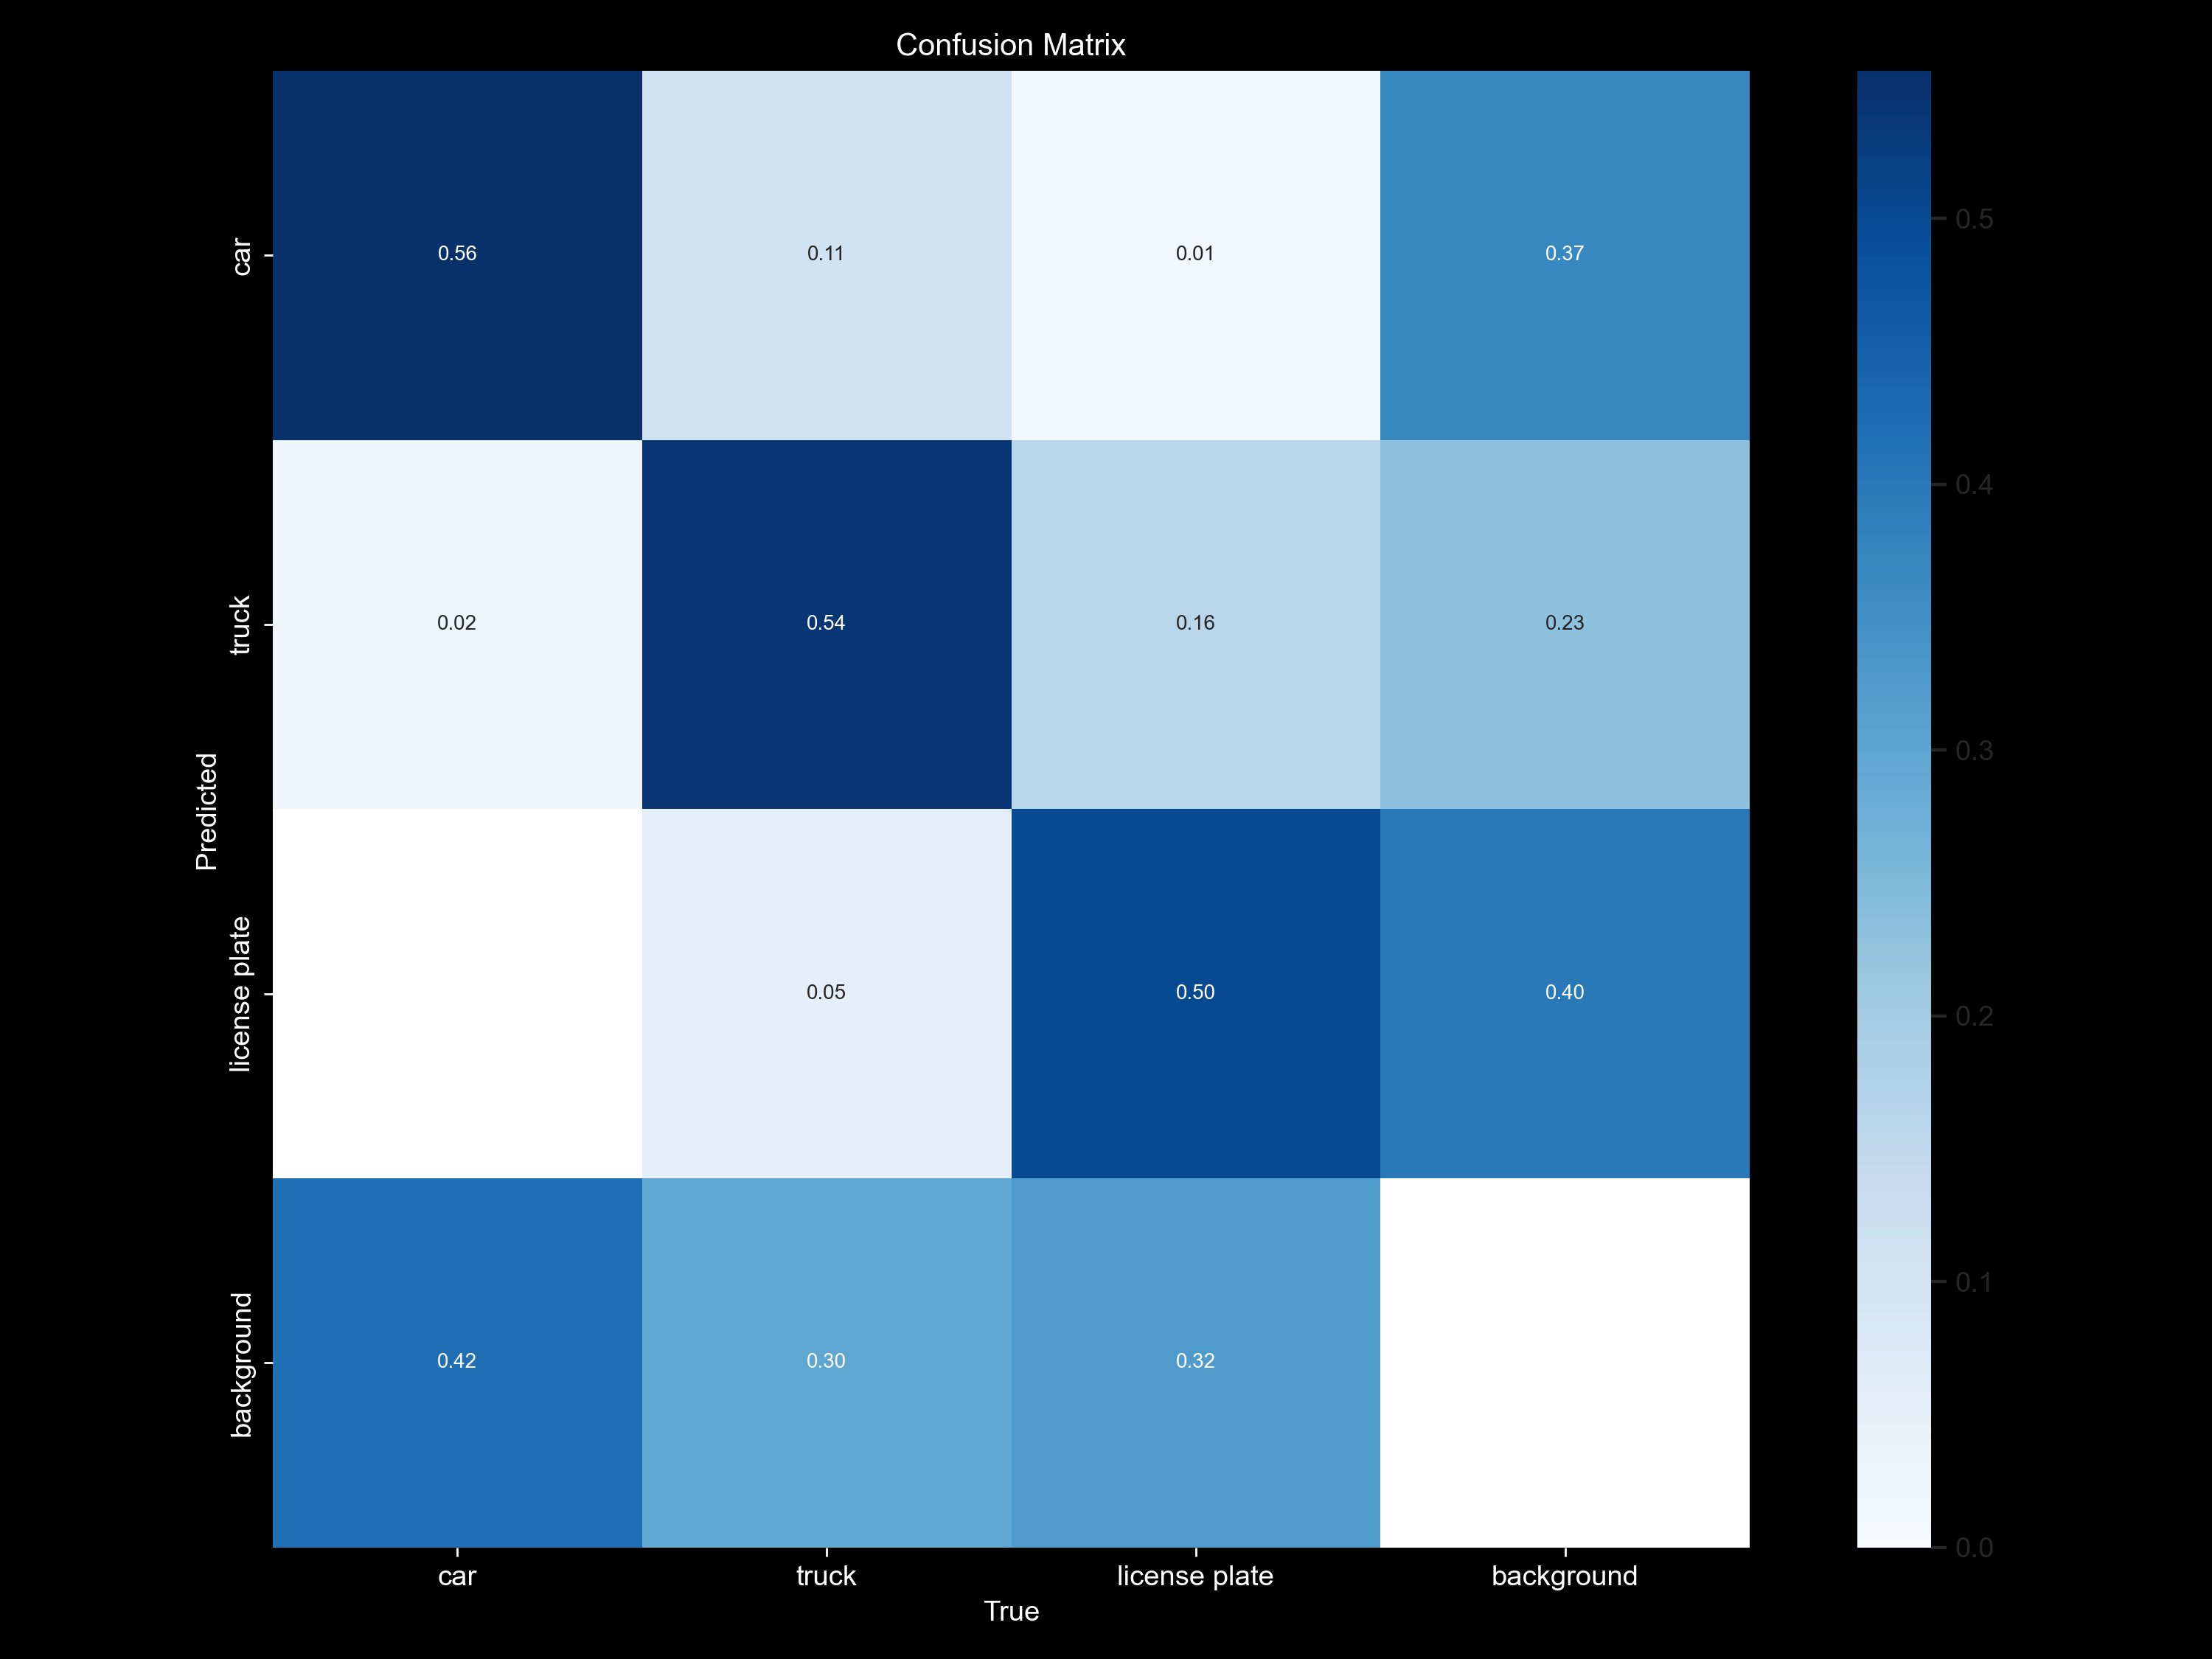

In [17]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/Users/eric/Desktop/2-Career/Projects/ObjectDetectionLL


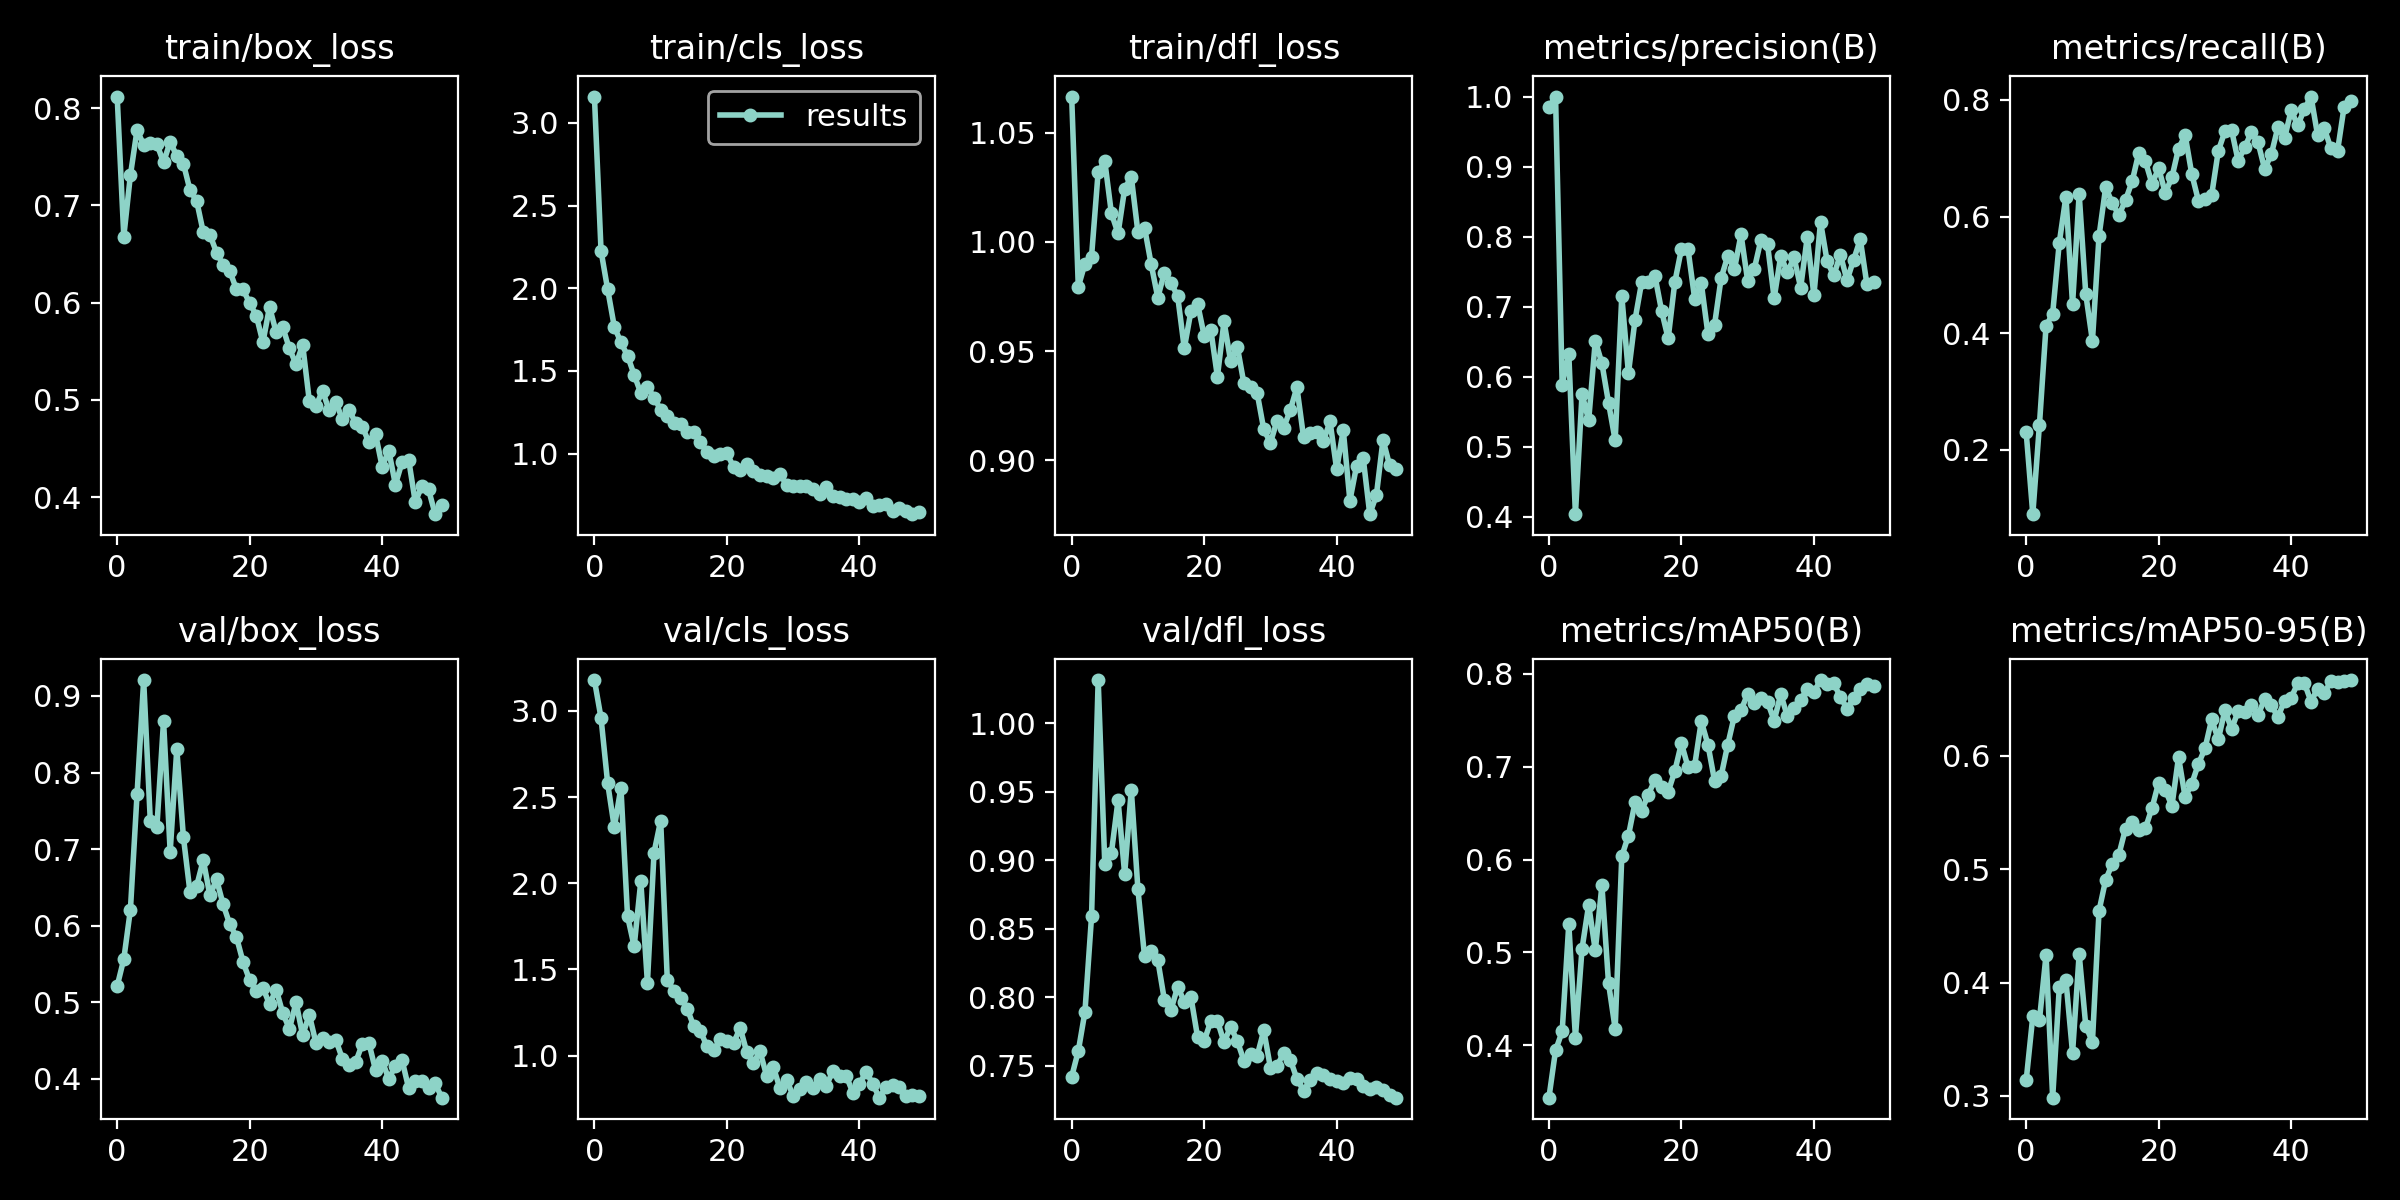

In [18]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/Users/eric/Desktop/2-Career/Projects/ObjectDetectionLL


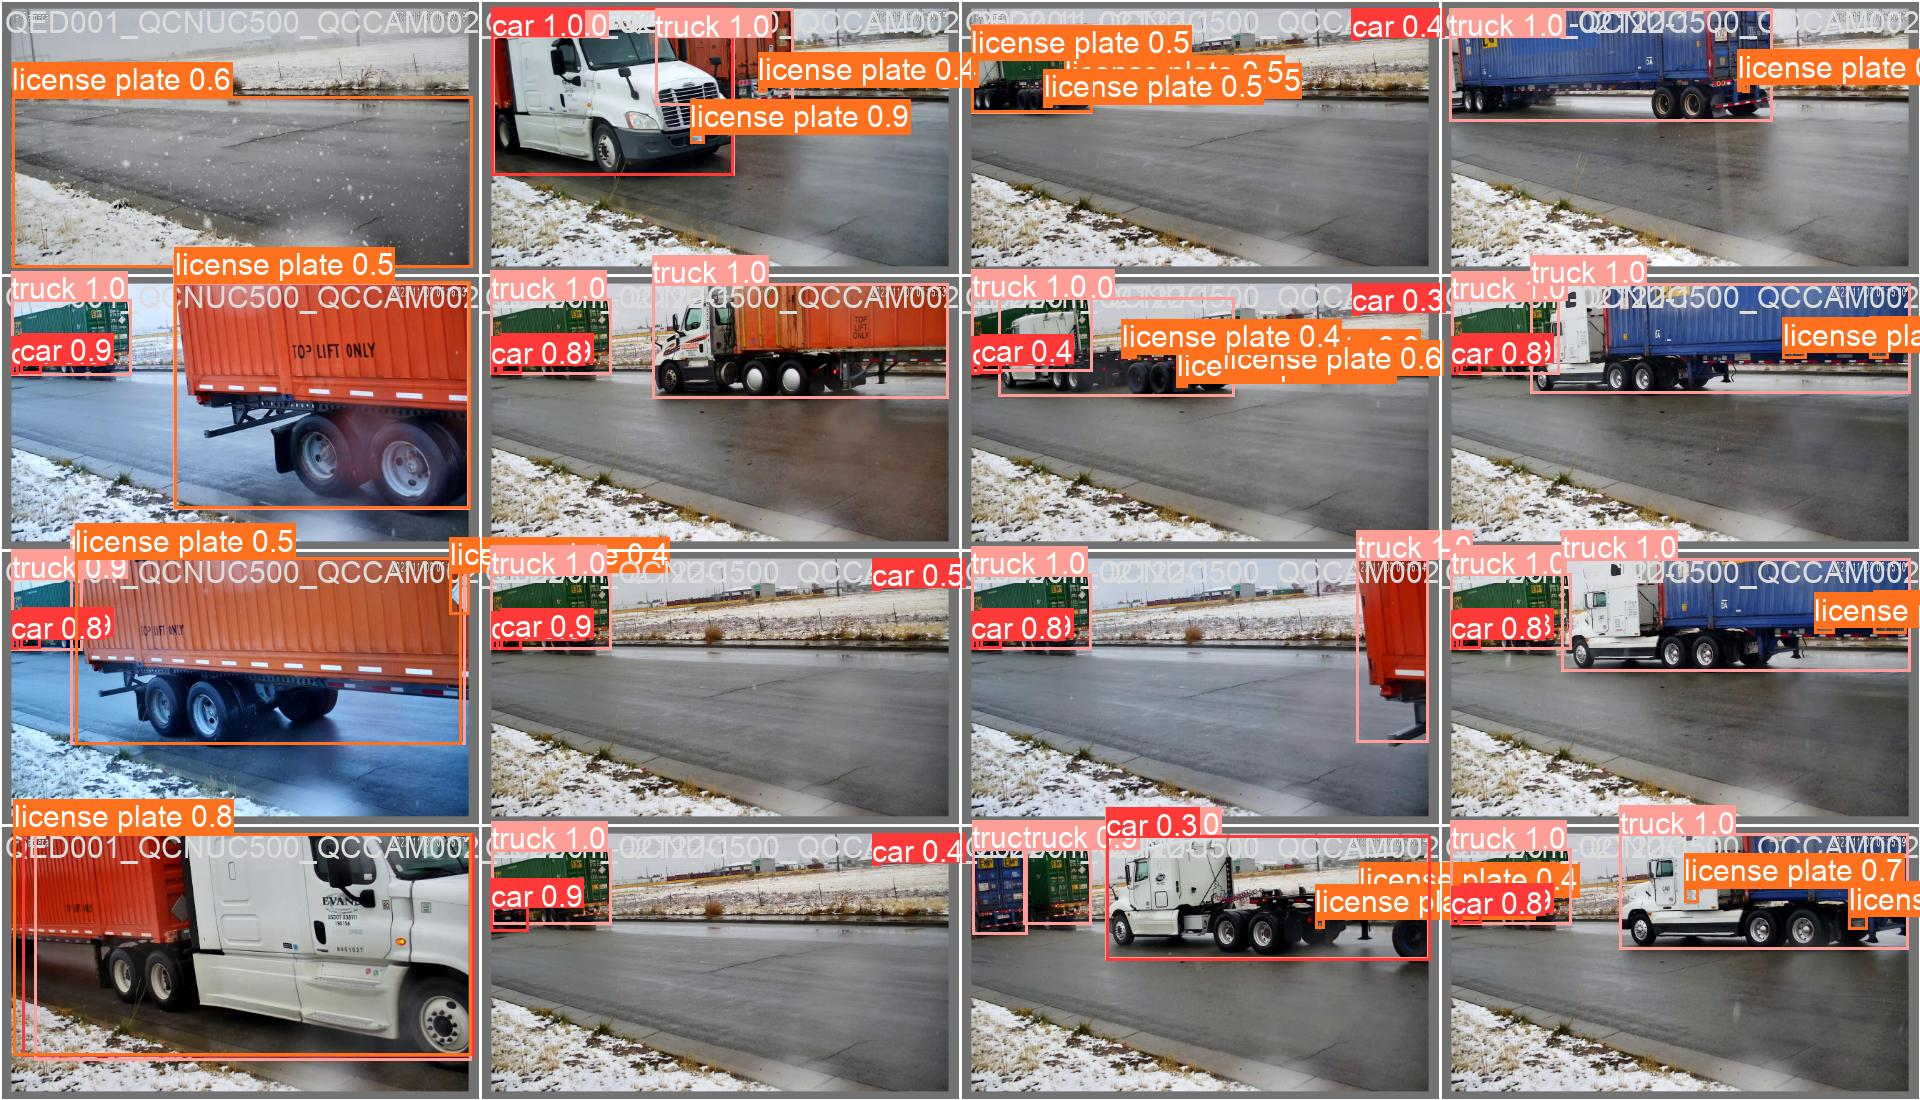

In [19]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## 🎬 Run Inference on a video

In [20]:
INPUT_VIDEO_PATH = TEST_VIDEO_PATHS[0]
OUTPUT_VIDEO_PATH = f"{HOME}/output.mp4"
TRAINED_MODEL_PATH = f"{HOME}/runs/detect/train/weights/best.pt"

In [21]:
!yolo predict model={TRAINED_MODEL_PATH} source={INPUT_VIDEO_PATH}

Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.1.0 CPU
[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs

video 1/1 (1/167) /Users/eric/Desktop/2-Career/Projects/ObjectDetectionLL/videos/QED001_QCNUC500_QCCAM002_2022-11-02T21-59-42.066001-UTC.mp4: 384x640 1 car, 237.5ms
video 1/1 (2/167) /Users/eric/Desktop/2-Career/Projects/ObjectDetectionLL/videos/QED001_QCNUC500_QCCAM002_2022-11-02T21-59-42.066001-UTC.mp4: 384x640 1 car, 174.9ms
video 1/1 (3/167) /Users/eric/Desktop/2-Career/Projects/ObjectDetectionLL/videos/QED001_QCNUC500_QCCAM002_2022-11-02T21-59-42.066001-UTC.mp4: 384x640 1 car, 98.1ms
video 1/1 (4/167) /Users/eric/Desktop/2-Career/Projects/ObjectDetectionLL/videos/QED001_QCNUC500_QCCAM002_2022-11-02T21-59-42.066001-UTC.mp4: 384x640 1 car, 75.8ms
video 1/1 (5/167) /Users/eric/Desktop/2-Career/Projects/ObjectDetectionLL/videos/QED001_QCNUC500_QCCAM002_2022-11-02T21-59-42.06